In [169]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import random
from sklearn.utils import shuffle
data=pd.read_csv("data_reduced.csv")
positionnan=[]
for i in data.columns:
    if data[i].dtype=="O":
        positionnan.append(i)
data.drop("gwgroupid" ,axis=1, inplace=True)
data.drop("countries_gwid", axis=1, inplace=True)
data.drop(positionnan, axis=1, inplace=True)
pd.set_option('max_rows', 50)
pd.set_option('max_columns', 500)

positionnan=[]
for i in data.index:
    if data["imr_mean_mean"][i]>1400:
        positionnan.append(i)
    
    if np.isnan(data["imr_mean_mean"][i]):
        positionnan.append(i)
        continue
    if data["year"][i]!=2000:
        positionnan.append(i)
data=data.drop(data.index[positionnan])

corrdata=data.corr()
positionnan=[]
for i in corrdata.columns:
    if np.isnan(corrdata[i][i]):
        positionnan.append(i)
data.drop(positionnan, axis=1, inplace=True)
corrdata=data.corr()
corrdata[corrdata.isnull()]=0

corr=corrdata.values
N=corrdata.shape[0]
data=shuffle(data)

In [170]:
#Kmeans Classification


k=15;
featuredwanted="imr_mean_mean"
keywordtore="imr"


c=[i*3 for i in range(k)]

D=np.zeros([N,k])
Classindex=np.zeros(N)
imrloc=corrdata.index.get_loc(featuredwanted)
for ii in range(500):
    Classset=[[c[i]] for i in range(k)]
    for i in range (N):
        if i in c:
            continue
        for j in range (k):
            D[i,j]=corr[i,c[j]]
        Classindex[i]=np.argsort(D[i])[k-1]
        Classset[int(Classindex[i])].append(i)
    for i in range(k):
        counting=0
        sum_of_distance_in_set=[]
        for p in Classset[i]:
            sum_of_distance_in_set.append(np.sum(abs(corr[int(p),j]) for j in Classset[i]))
            counting=counting+1
        #print(sum_of_distance_in_set)
        #print(np.argsort(sum_of_distance_in_set))
        c[i]=Classset[i][np.argsort(sum_of_distance_in_set)[counting-1]]
    for i in range(k-1):            
        for j in range(i+1,k):
            if corr[c[i],c[j]]>0.6:
                if len(Classset[i])>1:
                    Classset[j].append(c[i])
                    Classset[i].remove(c[i])
                    break
                    break
                 
    for i in range(k):
         counting=0
         sum_of_distance_in_set=[]
         for p in Classset[i]:
            sum_of_distance_in_set.append(np.sum(abs(corr[int(p),j]) for j in Classset[i]))
            counting=counting+1
        #print(sum_of_distance_in_set)
        #print(np.argsort(sum_of_distance_in_set))
         c[i]=Classset[i][np.argsort(sum_of_distance_in_set)[counting-1]]
    #print(Classset)    

centerfeatures=c
print(centerfeatures,imrloc)
#print(corrdata.index[centerfeatures])
correlatedindifferentgroup=[]
for i in Classset:
    if keywordtore in corrdata.index[i[abs(corrdata).iloc[i,imrloc].values.argsort()[-1]]]:
        correlatedindifferentgroup.append(i[abs(corrdata).iloc[i,imrloc].values.argsort()[-2]])
    else:
        correlatedindifferentgroup.append(i[abs(corrdata).iloc[i,imrloc].values.argsort()[-1]])

print(corrdata.index[correlatedindifferentgroup])
for i in Classset:
    print(corrdata.index[i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[77, 25, 6, 1, 49, 14, 18, 21, 103, 27, 34, 37, 32, 35, 86] 102
Index(['gdp95_corr', 'geo_typeid', 'status_senior', 'status_powerless',
       'incidence_flag', 'min_coastal_km', 'egippop', 'lexclpop',
       'diamsec_s_sum', 'upgraded1', 'upgraded10', 'downgraded_regaut_hist',
       'downgraded_hist', 'upgraded_regaut_hist', 'mean_coastal_km'],
      dtype='object')
Index(['gdp05_total', 'pop90_total', 'pop90_corr', 'pop00_total', 'pop00_corr',
       'pop10_total', 'pop10_corr', 'nightlight_total', 'gdp90_total',
       'gdp90_corr', 'gdp95_total', 'gdp95_corr', 'gdp00_total', 'gdp00_corr',
       'gdp05_corr', 'harvarea_sum', 'urban_gc_sum'],
      dtype='object')
Index(['rlbal', 'groupsize', 'status_pwrrank', 'status_monopoly',
       'status_dominant', 'status_egip', 'lsize', 'rbal', 'geo_typeid',
       'ed_lang1_size', 'goldsurface_s_sum'],
      dtype='object')
Index(['status_senior'], dtype='object')
Index(['statusid', 'status_powerless', 'status_discrim'], dtype='object')
In

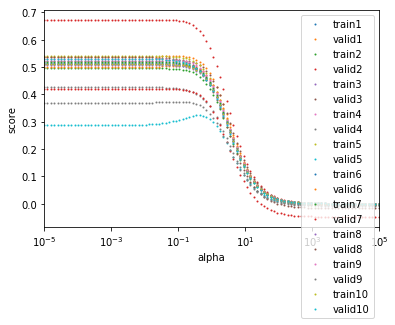

In [171]:
#exponential linear regression

data[data.isnull()]=0
datatrain=data.iloc[0:500]

datatest=data.iloc[500:560]

features=correlatedindifferentgroup
num_fold=10
label=[]
i=0
predictvalue=[]
coef=[]
xtestvector=np.log(datatest.iloc[:,features].values+ 1e-9)
ytestvector=np.log(datatest[featuredwanted].values+ 1e-9)
kf = KFold(n_splits=num_fold,shuffle=True)
for train_index, va_index in kf.split(datatrain.index):
    xtrainvector=np.log(datatrain.iloc[train_index,features].values+ 1e-9)
    ytrainvector=np.log(datatrain[featuredwanted].iloc[train_index].values+ 1e-9)
    xvalidvector=np.log(datatrain.iloc[va_index,features].values+ 1e-9)
    yvalidvector=np.log(datatrain[featuredwanted].iloc[va_index].values+ 1e-9)
    aspace=np.logspace(-5,5,100)
    trainscore=[]
    validscore=[]
    for a in aspace:
        model=Ridge(alpha=a,normalize=True)
        model.fit(xtrainvector,ytrainvector)
        xtrainpredict=model.predict(xtrainvector)
        xvalidpredict=model.predict(xvalidvector)
        trainscore.append(r2_score(ytrainvector,xtrainpredict))
        validscore.append(r2_score(yvalidvector,xvalidpredict))
    plt.scatter(aspace,trainscore,s=1)
    label.append("train"+str(i+1))
    plt.scatter(aspace,validscore,s=1)
    label.append("valid"+str(i+1))
    model=Ridge(alpha=aspace[np.asarray(validscore).argsort()[-1]],normalize=True)

    model.fit(xtrainvector,ytrainvector)
    coef.append(model.coef_)
    xtestpredict=model.predict(xtestvector)

    predictvalue.append(xtestpredict)
    #print(r2_score(ytestvector,xtestpredict))

    i=i+1
plt.legend(label)
plt.xscale('log')
plt.xlim(1e-5, 1e5)
plt.xlabel('alpha')
plt.ylabel('score')

plt.show()

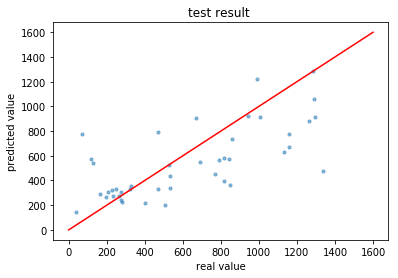

0.43571378292696583


In [172]:
predicted=[]
for i in range(len(predictvalue[0])):
    sum1=0
    count=0
    for j in range(len(predictvalue)):
        count=count+1
        sum1=sum1+np.exp(predictvalue[j][i])
    predicted.append(sum1/count)
plt.plot(np.linspace(0,1600,num=10),np.linspace(0,1600,num=10),color="r")  
plt.scatter(np.exp(ytestvector),predicted,alpha=0.5,s=10)
plt.title('test result ')
plt.xlabel('real value')
plt.ylabel('predicted value')
plt.show()
print(r2_score(np.exp(ytestvector),predicted))

Text(0, 0.5, 'different features')

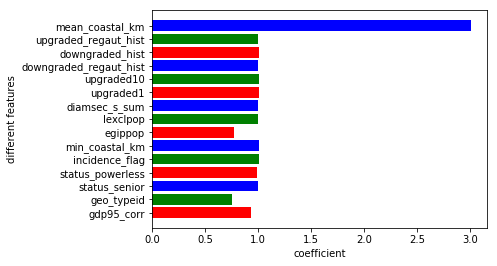

In [173]:
num_list=[]
for i in range(len(coef[0])):
    sum1=0
    count=0
    for j in range(len(coef)):
        count=count+1
        sum1=sum1+np.exp(coef[j][i])
    num_list.append(sum1/count)
name_list=corrdata.index[features]
powercoefficient=num_list

plt.barh(range(len(num_list)),num_list,color='rgb',tick_label=name_list)

plt.xlabel('coefficient')
plt.ylabel('different features')
#print(len(num_list),len(name_list))

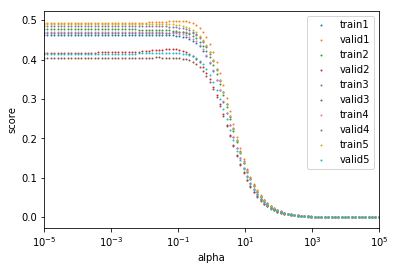

In [174]:
#simple linear regression

data[data.isnull()]=0
datatrain=data.iloc[0:450]
datatest=data.iloc[450:560]
features=correlatedindifferentgroup
num_fold=5
label=[]
i=0
predictvalue=[]
coef=[]
kf = KFold(n_splits=num_fold,shuffle=True)
for train_index, va_index in kf.split(datatrain.index):
    xtrainvector=datatrain.iloc[train_index,features].values
    ytrainvector=datatrain[featuredwanted].iloc[train_index].values
    xvalidvector=datatrain.iloc[va_index,features].values
    yvalidvector=datatrain[featuredwanted].iloc[va_index].values
    xtestvector=datatest.iloc[:,features].values
    ytestvector=datatest[featuredwanted].values
    #xtrainvector=np.log(datatrain.iloc[train_index,features].values+ 1e-9)
    #ytrainvector=np.log(datatrain[featuredwanted].iloc[train_index].values+ 1e-9)
    #xvalidvector=np.log(datatrain.iloc[va_index,features].values+ 1e-9)
    #yvalidvector=np.log(datatrain[featuredwanted].iloc[va_index].values+ 1e-9)
    train_x_mean = np.mean(xtrainvector, axis = 0) 
    train_x_std = np.std(xtrainvector, axis = 0)
    xtrainvector = (xtrainvector - train_x_mean)/(train_x_std + 1e-9)

    train_y_mean = np.mean(ytrainvector, axis = 0) 
    train_y_std = np.std(ytrainvector, axis = 0)
    ytrainvector = (ytrainvector - train_y_mean)/(train_y_std + 1e-9)

    valid_x_mean = np.mean(xvalidvector, axis = 0) 
    valid_x_std = np.std(xvalidvector, axis = 0)
    xvalidvector = (xvalidvector - valid_x_mean)/(valid_x_std + 1e-9)

    valid_y_mean = np.mean(yvalidvector, axis = 0) 
    valid_y_std = np.std(yvalidvector, axis = 0)
    yvalidvector = (yvalidvector - valid_y_mean)/(valid_y_std + 1e-9)

    test_x_mean = np.mean(xtestvector, axis = 0) 
    test_x_std = np.std(xtestvector, axis = 0)
    xtestvector = (xtestvector - test_x_mean)/(test_x_std + 1e-9)

    test_y_mean = np.mean(ytestvector, axis = 0) 
    test_y_std = np.std(ytestvector, axis = 0)

    ytestvector = (ytestvector - test_y_mean)/(test_y_std + 1e-9)
    
    #xtrainvector=cofpower(xtrainvector,powercoefficient)
    #xvalidvector=cofpower(xvalidvector,powercoefficient)
    #xtestvector=cofpower(xtestvector,powercoefficient)
    aspace=np.logspace(-5,5,100)
    trainscore=[]
    validscore=[]
    for a in aspace:
        model=Ridge(alpha=a,normalize=True)
        model.fit(xtrainvector,ytrainvector)
        xtrainpredict=model.predict(xtrainvector)
        xvalidpredict=model.predict(xvalidvector)
        trainscore.append(r2_score(ytrainvector,xtrainpredict))
        validscore.append(r2_score(yvalidvector,xvalidpredict))
    plt.scatter(aspace,trainscore,s=1)
    label.append("train"+str(i+1))
    plt.scatter(aspace,validscore,s=1)
    label.append("valid"+str(i+1))
    model=Ridge(alpha=aspace[np.asarray(validscore).argsort()[-1]],normalize=True)
    
    model.fit(xtrainvector,ytrainvector)
    coef.append(model.coef_)
    xtestpredict=model.predict(xtestvector)

    predictvalue.append(xtestpredict)
    #print(r2_score(ytestvector,xtestpredict))

    i=i+1
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend(label)
plt.xscale('log')
plt.xlim(1e-5, 1e5)

plt.show()

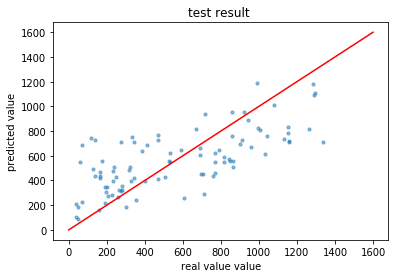

0.49710106601840687


In [175]:
predicted=[]
for i in range(len(predictvalue[0])):
    sum1=0
    count=0
    for j in range(len(predictvalue)):
        count=count+1
        sum1=sum1+predictvalue[j][i]
    predicted.append(sum1/count)
plt.plot(np.linspace(0,1600,num=10),np.linspace(0,1600,num=10),color="r")    
plt.scatter(ytestvector/(1/test_y_std)+test_y_mean,predicted/(1/test_y_std)+test_y_mean,alpha=0.5,s=10)
plt.title('test result ')
plt.xlabel('real value value')
plt.ylabel('predicted value')
plt.show()
print(r2_score(ytestvector/(1/test_y_std)+test_y_mean,predicted/(1/test_y_std)+test_y_mean))

Text(0, 0.5, 'different features')

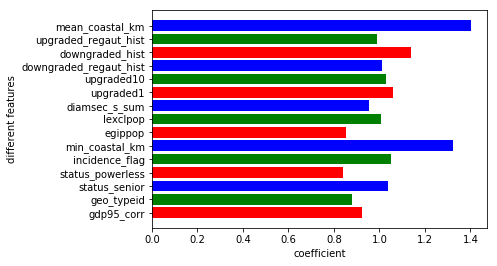

In [176]:
num_list=[]
for i in range(len(coef[0])):
    sum1=0
    count=0
    for j in range(len(coef)):
        count=count+1
        sum1=sum1+np.exp(coef[j][i])
    num_list.append(sum1/count)
name_list=corrdata.index[features]
plt.barh(range(len(num_list)),num_list,color='rgb',tick_label=name_list)
plt.xlabel('coefficient')
plt.ylabel('different features')